In [1]:
data_dir = 'anime/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import model
from torchvision import datasets
from torchvision import transforms

%matplotlib inline

# Process training data

In [2]:
def get_dataloader(batch_size, image_size, data_dir='anime/'):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
    
    return data_loader


In [3]:
# Define function hyperparameters
batch_size = 128
img_size = 32

# Call your function and get a dataloader
train_loader = get_dataloader(batch_size, img_size)

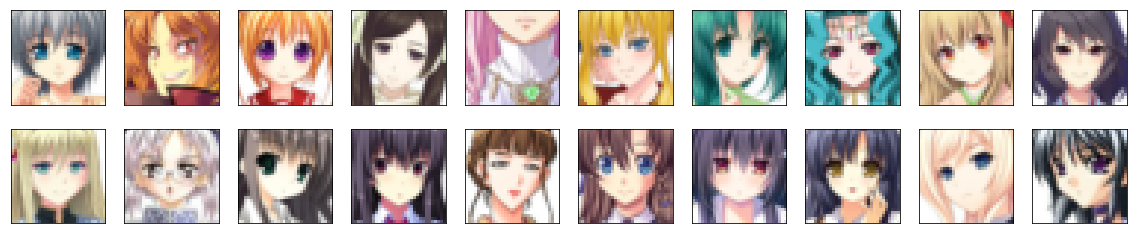

In [4]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [5]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    
    min, max = torch.min(x), torch.max(x)
    x = 2 * ((x - min) / (min + max)) - 1
    
    return x

In [6]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9231)


# Prepare the models

In [7]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

In [8]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = model.Discriminator(d_conv_dim)
    G = model.Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [9]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

# Train the models

In [10]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [11]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [12]:
def real_loss(D_out):
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size) * 0.9
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [13]:
def train(D, G, train_loader, n_epochs, print_every=50):
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    z_size=100
    
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # perfom backprop
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses


In [14]:
# set number of epochs 
n_epochs = 25

# call training function
losses = train(D, G, train_loader, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 1.4896 | g_loss: 1.1585
Epoch [    1/   25] | d_loss: 0.6008 | g_loss: 5.0280
Epoch [    1/   25] | d_loss: 0.7235 | g_loss: 3.6336
Epoch [    1/   25] | d_loss: 1.0004 | g_loss: 5.1635
Epoch [    2/   25] | d_loss: 0.5945 | g_loss: 3.1241
Epoch [    2/   25] | d_loss: 0.6821 | g_loss: 2.9460
Epoch [    2/   25] | d_loss: 0.8256 | g_loss: 3.2018
Epoch [    2/   25] | d_loss: 0.7688 | g_loss: 3.4114
Epoch [    3/   25] | d_loss: 0.8670 | g_loss: 2.9881
Epoch [    3/   25] | d_loss: 0.8430 | g_loss: 1.6656
Epoch [    3/   25] | d_loss: 0.6961 | g_loss: 2.9167
Epoch [    3/   25] | d_loss: 1.1456 | g_loss: 3.0854
Epoch [    4/   25] | d_loss: 0.8483 | g_loss: 2.9210
Epoch [    4/   25] | d_loss: 0.9689 | g_loss: 2.3923
Epoch [    4/   25] | d_loss: 0.9777 | g_loss: 2.8403
Epoch [    4/   25] | d_loss: 1.1714 | g_loss: 2.5573
Epoch [    5/   25] | d_loss: 1.1951 | g_loss: 3.5204
Epoch [    5/   25] | d_loss: 0.9773 | g_loss: 2.2655
Epoch [    5/   25] | d_loss

# Save the models

In [15]:
torch.save(G.state_dict(), "g.pth")
torch.save(D.state_dict(), "d.pth")